# コード2-3：線形常微分方程式の数値計算の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

線形常微分方程式を数値計算する例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

- deSolve https://desolve.r-forge.r-project.org/

In [2]:
## 必要があればインストール
# install.packages("ggplot2", "patchwork", "deSolve)

In [3]:
rm(list = ls(all = TRUE))
library(ggplot2)
library(patchwork)
library(deSolve)

## 線形常微分方程式の数値計算

式（2.8）

$$
\begin{align}
\frac{d I \left( t \right)}{dt} &= \beta T(0) V(t) - \delta I(t) \\
\frac{d V \left( t \right)}{dt} &= p I(t) - c V(t)
\end{align}
$$

について、
- $\beta = 0.00000006, \delta = 0.5, p = 100, c = 20, T(0) = 1000, I(0) = 10, V(0) = 20$
- $\beta = 0.000006, \delta = 0.5, p = 1000, c = 20, T(0) = 1000, I(0) = 10, V(0) = 20$
の時の$I(t), V(t)$を数値計算によって求める。

deSolveパッケージに含まれるode関数を使う。  
https://www.rdocumentation.org/packages/deSolve/versions/1.40/topics/ode

In [4]:
## 計算する時刻の設定
Tmin <- 0.0
Tmax <- 10.0
step_size <- 0.0001

## パラメータの設定
## beta, delta, p, c, T(0), I(0), V(0)
pars1 <- c(0.00000006, 0.5, 100, 20, 10000, 10, 20)
pars2 <- c(0.0000006, 0.5, 1000, 20, 10000, 10, 20)

In [30]:
## 傾き（微分）の定義
ode_derives <- function(t, var, pars) {
    with(as.list(c(var, pars)), {
        dIdt <- beta * T0 * VL - delta * IC
        dVdt <- p * IC - c * VL
        
        return(list(c(dIdt, dVdt)))
    })
}

## パラメータを受け取ってode関数に渡す関数
ODEs <- function(parms) {
    pars <- parms[1:5]
    names(pars) <- c("beta", "delta", "p", "c", "T0")
    
    ## 計算のタイムステップ
    t_list <- seq(Tmin, Tmax, by = step_size)
    ## 初期値 I(0), V(0)
    var_init <- c(IC = parms[6], VL = parms[7])
    ## 微分方程式の計算
    out <- ode(y = var_init, times = t_list, func = ode_derives, parms = pars)
    
    as.data.frame(out)
}

In [31]:
out1 <- ODEs(pars1)
out2 <- ODEs(pars2)

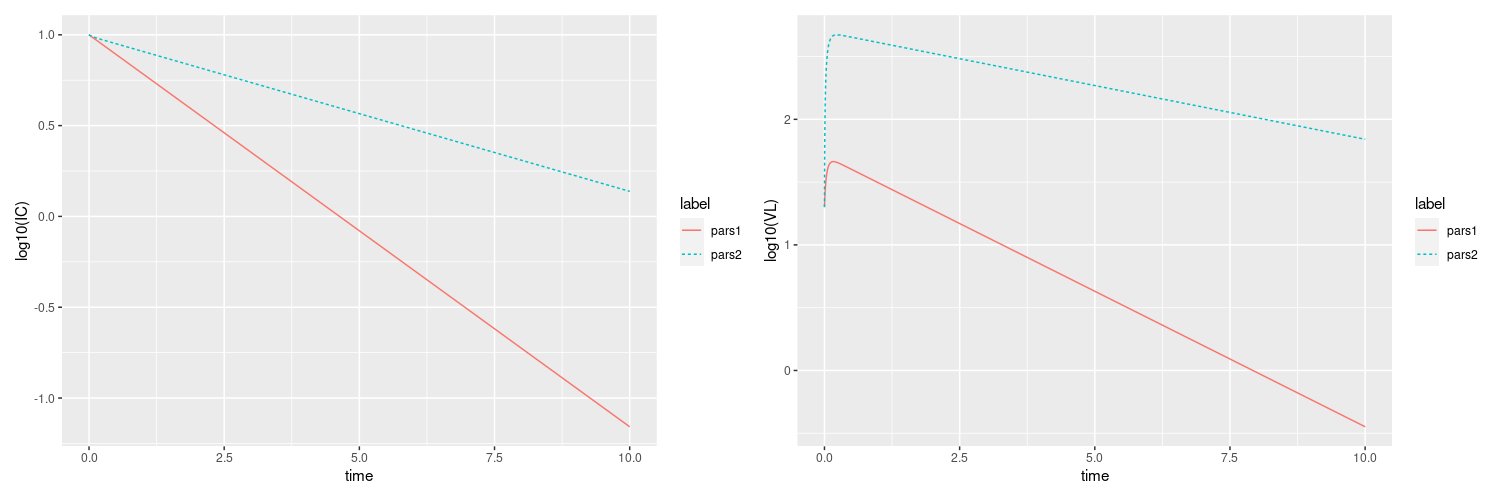

In [47]:
data_plot <- rbind(cbind(out1, label = "pars1"), cbind(out2, label = "pars2"))

## I(t)のプロット
p1 <- ggplot(data = data_plot, aes(x = time, y = log10(IC), color = label, linetype = label)) +
    geom_line()

## V(t)のプロット
p2 <- ggplot(data = data_plot, aes(x = time, y = log10(VL), color = label, linetype = label)) +
    geom_line()

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2

## 解析解を用いた確認

式（2.8）の解析解は式（2.10）

$$
\begin{align}
I(t) &= \frac{\beta T(0) V(0) - \left(\delta + \theta _2 \right) I(0)}
              {\theta_1- \theta_2}
          \left(e^{ \theta_1 t }-e^{\theta_2 t} \right)
          + I(0) e^{\theta_2 t} \\
V(t) &= \frac{pI(0) - \left( c + \theta_2 \right) I(0)}
              {\theta_1- \theta_2}
          \left(e^{ \theta_1 t }-e^{\theta_2 t} \right)
          + V(0) e^{\theta_2 t} 
\end{align}
$$

であり、ここで

$$
\begin{align}
\theta_1 &= \frac{-(\delta + c) + \sqrt{(\delta - c)^2 + 4 \beta pT(0) }}{2} \\
\theta_2 &= \frac{-(\delta + c) - \sqrt{(\delta - c)^2 + 4 \beta pT(0) }}{2}
\end{align}
$$

である。

数値解と重ねてプロットしてみる。

In [53]:
## パラメータを受け取ってtheta_1の値を返す関数
theta1 <- function(parms) {
  beta <- parms[1]
  delta <- parms[2]
  p <- parms[3]
  c <- parms[4]
  T0 <- parms[5]

  return((- (delta + c) + sqrt((delta - c)**2 + 4*beta*p*T0)) / 2)
}

## パラメータを受け取ってtheta_2の値を返す関数
theta2 <- function(parms) {
  beta <- parms[1]
  delta <- parms[2]
  p <- parms[3]
  c <- parms[4]
  T0 <- parms[5]

  return((- (delta + c) - sqrt((delta - c)**2 + 4*beta*p*T0)) / 2)
}

## パラメータを受け取って解析解を返す関数
ODEs_analytical <- function(parms) {
  ## パラメータ
  beta <- parms[1]
  delta <- parms[2]
  p <- parms[3]
  c <- parms[4]
  T0 <- parms[5]
  I0 <- parms[6]
  V0 <- parms[7]

  ## 時間のリスト
  t_list <- seq(Tmin, Tmax, by = step_size)

  ## パラメータの値から計算されるtheta_1
  theta1_c <- theta1(parms)
  ## パラメータの値から計算されるtheta_2
  theta2_c <- theta2(parms)

  ## I(t)の解析解の値
  I_list <- ((beta * T0 * V0 - (delta + theta2_c) * I0) / (theta1_c - theta2_c)) *
    (exp(theta1_c * t_list) - exp(theta2_c * t_list)) + I0 * exp(theta2_c * t_list)
  ## V(t)の解析解の値
  V_list <- ((p * I0 - (c + theta2_c) * I0) / (theta1_c - theta2_c)) *
    (exp(theta1_c * t_list) - exp(theta2_c * t_list)) + V0 * exp(theta2_c * t_list)

  return(data.frame(time = t_list, IC = I_list, VL = V_list))
}

In [54]:
## 解析解
out_analytical <- ODEs_analytical(pars1)

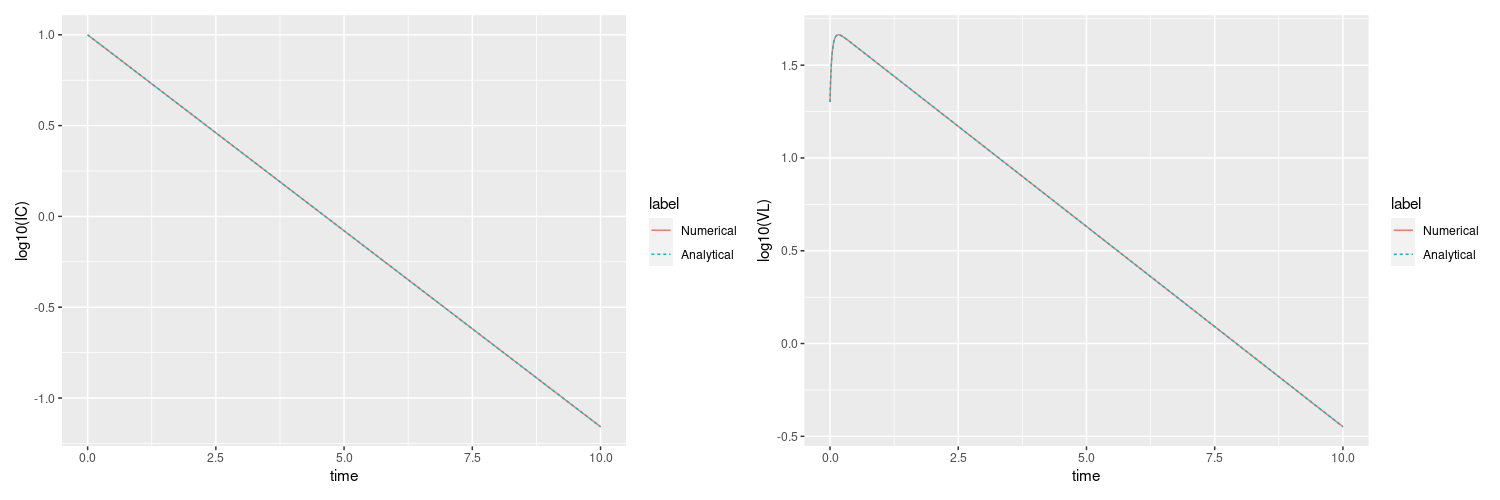

In [56]:
data_plot <- rbind(cbind(out1, label = "Numerical"), cbind(out_analytical, label = "Analytical"))
data_plot$label <- factor(data_plot$label, levels = c("Numerical", "Analytical"))

## I(t)のプロット
p1 <- ggplot(data = data_plot, aes(x = time, y = log10(IC), color = label, linetype = label)) +
    geom_line()

## V(t)のプロット
p2 <- ggplot(data = data_plot, aes(x = time, y = log10(VL), color = label, linetype = label)) +
    geom_line()

p1 + p2